In [1]:
import tensorflow as tf
import cleverhans
import numpy as np
import matplotlib.pyplot as plt
import keras
import foolbox
import pprint as pp
from PIL import Image
from keras.preprocessing import image as img
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_image(extension: str):
  img_path = f'{extension}.jpg'
  image = img.load_img(img_path, target_size=(224, 224))
  plt.imshow(image)
  x = img.img_to_array(image)
  # x = np.expand_dims(x, axis=0)
  # x = preprocess_input(x)
  return x

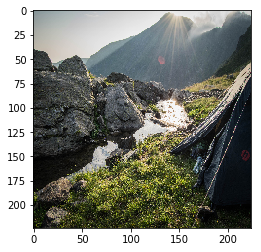

In [3]:
img2 = load_image('DSC_0897')
image, label = foolbox.utils.imagenet_example()
assert (img2.shape, img2.max(), type(img2))==(image.shape, image.max(), type(image))

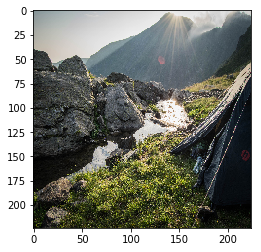

In [4]:
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50

# instantiate model
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

image = load_image('DSC_0897')
to_classify = np.expand_dims(image, axis=0)
preds = kmodel.predict(to_classify)
label = np.argmax(preds)

# apply attack on source image
# ::-1 reverses the color channels, because Keras ResNet50 expects BGR instead of RGB
attack = foolbox.attacks.FGSM(fmodel, threshold=.5)
adversarial = attack(image[:, :, ::-1], label)
# if the attack fails, adversarial will be None and a warning will be printed

In [5]:
print('Predicted:', pp.pprint(decode_predictions(preds, top=20)[0]))

[('n03792972', 'mountain_tent', 0.68727505),
 ('n09399592', 'promontory', 0.07355865),
 ('n09468604', 'valley', 0.07171795),
 ('n04606251', 'wreck', 0.025214558),
 ('n09428293', 'seashore', 0.018810693),
 ('n01498041', 'stingray', 0.01020383),
 ('n04366367', 'suspension_bridge', 0.00910297),
 ('n02077923', 'sea_lion', 0.008893944),
 ('n09472597', 'volcano', 0.0077157747),
 ('n09421951', 'sandbar', 0.0056634448),
 ('n09193705', 'alp', 0.0052817613),
 ('n09256479', 'coral_reef', 0.005070684),
 ('n03042490', 'cliff_dwelling', 0.0048538684),
 ('n03788365', 'mosquito_net', 0.0040941825),
 ('n03450230', 'gown', 0.003981212),
 ('n09246464', 'cliff', 0.0034005924),
 ('n04507155', 'umbrella', 0.00259821),
 ('n09332890', 'lakeside', 0.0024168892),
 ('n02951358', 'canoe', 0.0020540736),
 ('n03160309', 'dam', 0.0020333952)]
Predicted: None


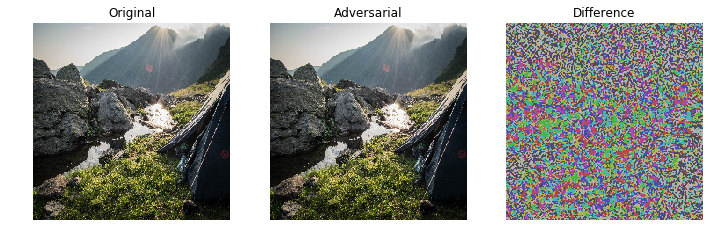

In [6]:
plt.figure(figsize=(12,12))

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(image / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

In [7]:
new_preds = kmodel.predict(np.expand_dims(adversarial, axis=0))
print('Predicted:', pp.pprint(decode_predictions(new_preds, top=20)[0]))

[('n04366367', 'suspension_bridge', 0.27551892),
 ('n03792972', 'mountain_tent', 0.26759607),
 ('n09472597', 'volcano', 0.25710547),
 ('n09468604', 'valley', 0.09390604),
 ('n09193705', 'alp', 0.03466299),
 ('n09246464', 'cliff', 0.030121733),
 ('n04346328', 'stupa', 0.008299703),
 ('n09399592', 'promontory', 0.0055106645),
 ('n09332890', 'lakeside', 0.0038562394),
 ('n03160309', 'dam', 0.0020365235),
 ('n02965783', 'car_mirror', 0.0017434784),
 ('n03788365', 'mosquito_net', 0.0015232521),
 ('n04275548', 'spider_web', 0.0014818179),
 ('n04613696', 'yurt', 0.0013899272),
 ('n03891251', 'park_bench', 0.0012903691),
 ('n02104365', 'schipperke', 0.001013231),
 ('n02667093', 'abaya', 0.0010092475),
 ('n09428293', 'seashore', 0.00091121765),
 ('n02951358', 'canoe', 0.0007187614),
 ('n03000134', 'chainlink_fence', 0.0005480902)]
Predicted: None


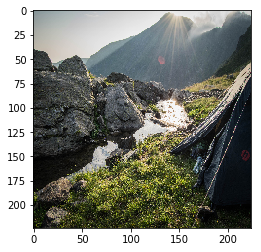

In [8]:
plt.imshow(image / 255)

In [9]:
# !wget https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0897.jpg
# !wget https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0896.jpg

In [10]:
mu_list = range(50, 200, 10)
sigma_list = range(10, 100, 2)
storage_df = pd.DataFrame()

for mu, sigma in zip(mu_list, sigma_list):
    rand_noise = np.random.normal(loc=mu, scale=sigma, size=(224,224, 3))
    rand_noise = np.clip(rand_noise, 0, 255.)
    noise_preds = kmodel.predict(np.expand_dims(rand_noise, axis=0))
    predictions = decode_predictions(noise_preds, top=20)[0]
    new_df = pd.DataFrame(predictions, columns=['id','class','prediction'])
    new_df['sigma'] = sigma
    new_df['mu'] = mu
    storage_df = pd.concat([new_df, storage_df])
    

In [11]:
descr = storage_df.groupby(['sigma','mu']).describe()
max_vals = descr.prediction['max'].sort_values(ascending=False).reset_index()
max_vals

sigma   mu       max
0      10   50  0.172480
1      12   60  0.127144
2      30  150  0.104485
3      28  140  0.096029
4      14   70  0.090681
5      16   80  0.081054
6      26  130  0.079419
7      18   90  0.073316
8      22  110  0.072660
9      38  190  0.071220
10     24  120  0.068107
11     32  160  0.067800
12     36  180  0.063652
13     20  100  0.063044
14     34  170  0.052506

In [12]:
sigma_list = list(max_vals.sigma)
mu_list = list(max_vals.mu)

In [13]:
rand_noise = np.random.normal(loc=60, scale=12, size=(224,224, 3))
rand_noise = np.clip(rand_noise, 0, 255.)
noise_preds = kmodel.predict(np.expand_dims(rand_noise, axis=0))
predictions = decode_predictions(noise_preds, top=20)[0]
new_df = pd.DataFrame(predictions, columns=['id','class','prediction'])
new_df['sigma'] = sigma
new_df['mu'] = mu
new_df

id           class  prediction  sigma   mu
0   n01776313            tick    0.168396     38  190
1   n04548280      wall_clock    0.039748     38  190
2   n01828970       bee_eater    0.032217     38  190
3   n04153751           screw    0.030725     38  190
4   n02783161       ballpoint    0.030136     38  190
5   n04266014   space_shuttle    0.028824     38  190
6   n01608432            kite    0.028178     38  190
7   n02002724     black_stork    0.023654     38  190
8   n04372370          switch    0.023559     38  190
9   n01560419          bulbul    0.020912     38  190
10  n02264363        lacewing    0.018674     38  190
11  n01616318         vulture    0.017385     38  190
12  n03291819        envelope    0.016717     38  190
13  n01614925      bald_eagle    0.014151     38  190
14  n03729826      matchstick    0.013597     38  190
15  n03888257       parachute    0.013410     38  190
16  n02165456         ladybug    0.011196     38  190
17  n04127249      safety_pin    0.009527     38  190
18  n01537544  indigo_bunting    0.009298     38  190
19  n02219486             ant    0.008533     38  190

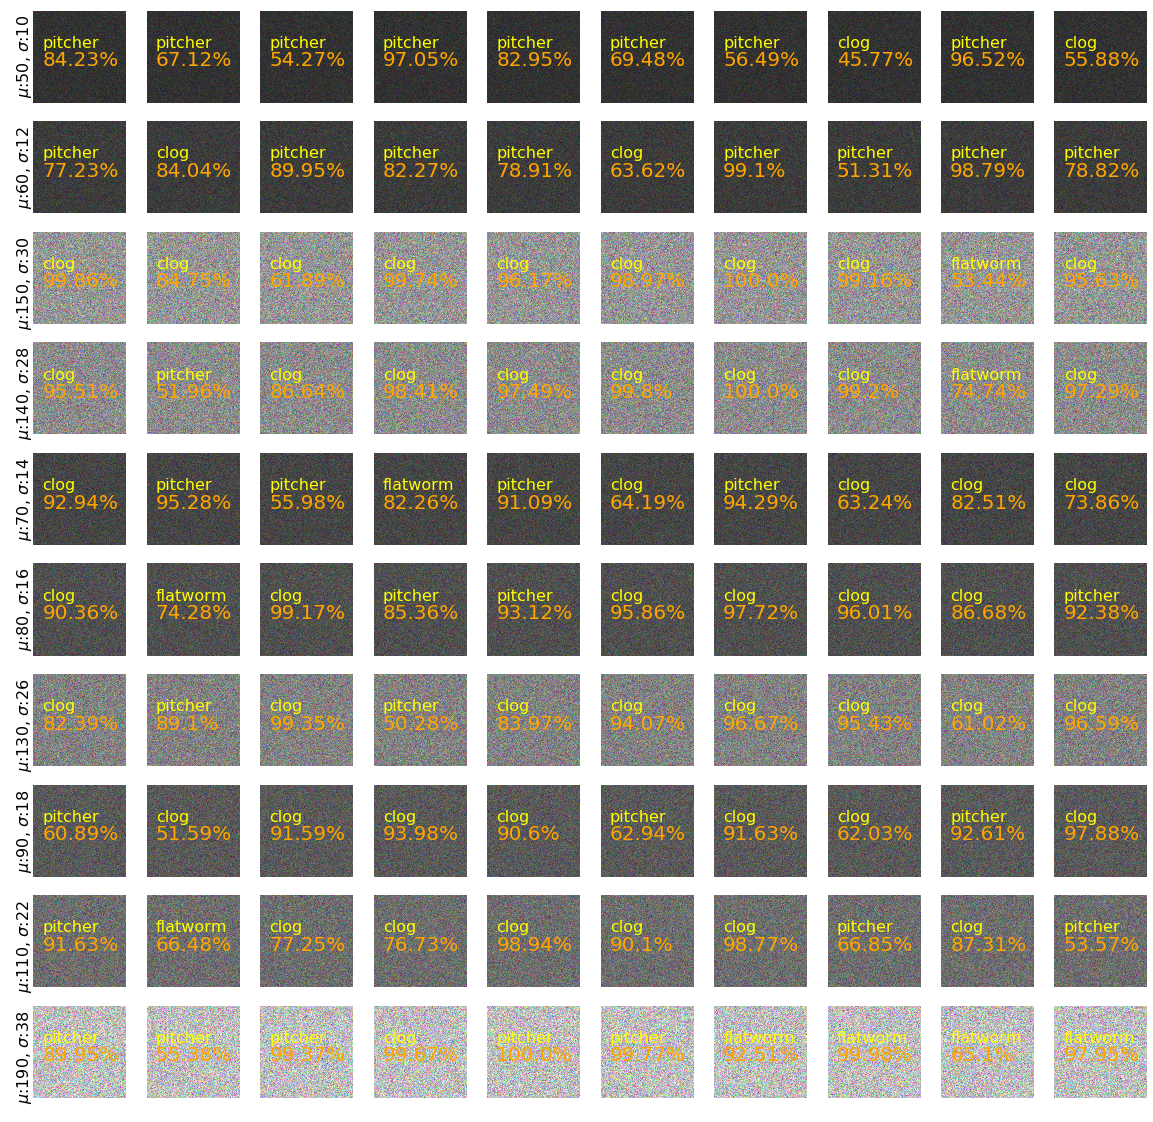

In [53]:
fig = plt.figure(figsize=(20,20))
mu = 50
sigma = 10
sigma_list = list(max_vals.sigma)
mu_list = list(max_vals.mu)

def make_subplot(x, y, z, new_row=False):
    rand_noise = np.random.normal(loc=mu, scale=sigma, size=(224,224, 3))
    rand_noise = np.clip(rand_noise, 0, 255.)
    noise_preds = kmodel.predict(np.expand_dims(rand_noise, axis=0))
    prediction, num = decode_predictions(noise_preds, top=20)[0][0][1:3]
    num = round(num * 100, 2)
    ax = fig.add_subplot(x,y,z)
    ax.annotate(prediction, xy=(0.1, 0.6), xycoords=ax.transAxes, fontsize=16, color='yellow')
    ax.annotate(f'{num}%' , xy=(0.1, 0.4), xycoords=ax.transAxes, fontsize=20, color='orange')
    if new_row:
        ax.annotate(f'$\mu$:{mu}, $\sigma$:{sigma}' , xy=(-.2, 0.8), xycoords=ax.transAxes,
                    rotation=90, fontsize=16, color='black')
    ax.imshow(rand_noise / 255)  # division by 255 to convert [0, 255] to [0, 1]
    ax.axis('off')

    
for i in range(1,101):
    if (i-1) % 10==0:
        mu = mu_list.pop(0)
        sigma = sigma_list.pop(0)
        make_subplot(10,10, i, new_row=True)
    else:
        make_subplot(10,10, i)

plt.show()

In [50]:
from keras.applications.inception_v3 import InceptionV3

# instantiate model
keras.backend.set_learning_phase(0)
kmodel = InceptionV3(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

96116736/96112376 [==============================] - 68s 1us/step


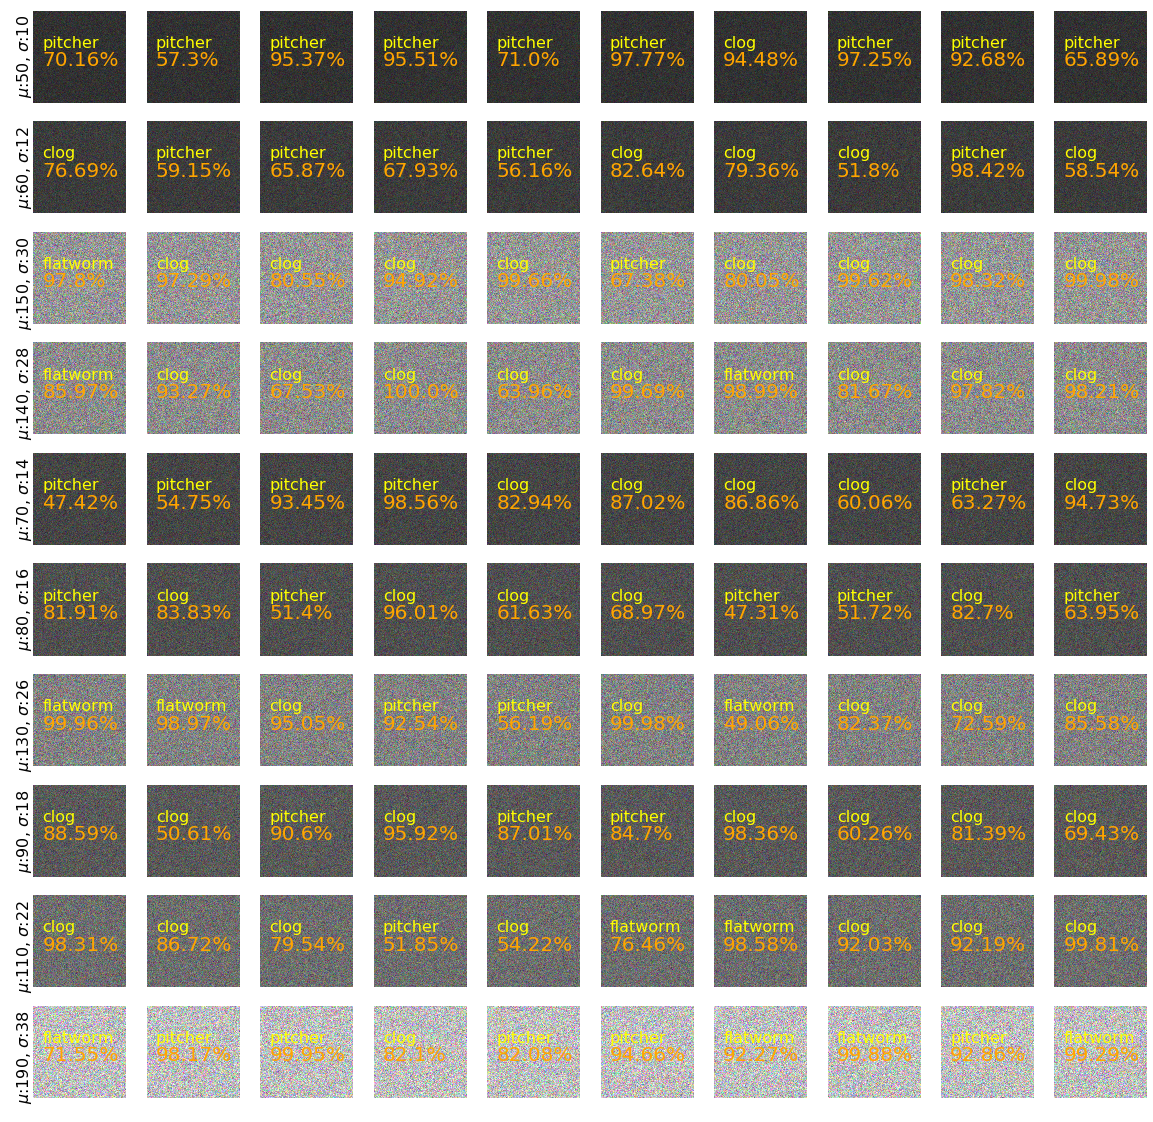

In [55]:
fig = plt.figure(figsize=(20,20))
mu = 50
sigma = 10
sigma_list = list(max_vals.sigma)
mu_list = list(max_vals.mu)

def make_subplot(x, y, z, new_row=False):
    rand_noise = np.random.normal(loc=mu, scale=sigma, size=(224,224, 3))
    rand_noise = np.clip(rand_noise, 0, 255.)
    first_pred = kmodel.predict(np.expand_dims(rand_noise, axis=0))
    label = np.argmax(first_pred)
    attack = foolbox.attacks.MomentumIterativeAttack(fmodel, 
                                                     distance=foolbox.distances.Linfinity)
    adversarial = attack(rand_noise[:, :, ::-1], label, unpack=False)
    adversarial = adversarial.image
    noise_preds = kmodel.predict(np.expand_dims(adversarial, axis=0))
    prediction, num = decode_predictions(noise_preds, top=20)[0][0][1:3]
    num = round(num * 100, 2)
    ax = fig.add_subplot(x,y,z)
    ax.annotate(prediction, xy=(0.1, 0.6), xycoords=ax.transAxes, fontsize=16, color='yellow')
    ax.annotate(f'{num}%' , xy=(0.1, 0.4), xycoords=ax.transAxes, fontsize=20, color='orange')
    if new_row:
        ax.annotate(f'$\mu$:{mu}, $\sigma$:{sigma}' , xy=(-.2, 0.8), xycoords=ax.transAxes,
                    rotation=90, fontsize=16, color='black')
    ax.imshow(adversarial / 255)  # division by 255 to convert [0, 255] to [0, 1]
    ax.axis('off')

    
for i in range(1,101):
    if (i-1) % 10==0:
        mu = mu_list.pop(0)
        sigma = sigma_list.pop(0)
        make_subplot(10,10, i, new_row=True) 
    else:
        make_subplot(10,10, i)

plt.show()